In [207]:
### Author: r-n96
### Date Created:
### Python: 3.7.1v

In [208]:
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
import random
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
from pandas_datareader import wb
import pandas_ta as ta
import requests
from bs4 import BeautifulSoup
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns 


In [209]:
endDate = datetime.date(2024,1,1)
startDate = endDate - datetime.timedelta(days=365*5)

# 1. Data Prep

In [210]:
#Download Tickers list of S&P 500 companies

# Wikipedia URL
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, "html.parser")

    # Find the table containing the S&P 500 company data
    table = soup.find("table", {"class": "wikitable"})

    # Extract tickers from the table and store them in a list
    tickers = []
    for row in table.find_all("tr")[1:]:
        columns = row.find_all("td")
        ticker = columns[0].text.strip()
        tickers.append(ticker)

    print("Tickers have been successfully extracted and stored in the 'tickers' list.")
else:
    print(f"Failed to retrieve data. Status Code: {response.status_code}")


Tickers have been successfully extracted and stored in the 'tickers' list.


In [211]:
yf.pdr_override() #This is necessary because Yahoo Finance changed its API, and yfinance provides an updated implementation for fetching data from Yahoo Finance

stockdata = pdr.DataReader(tickers=tickers, start=startDate, end = endDate)

#Keep Adj Close only and drop any column tht has an NaN value
stockdata = stockdata.dropna(axis=1, how='any')

stockdata.columns = stockdata.columns.set_names(['Variable', 'Ticker'])

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-01-02 -> 2024-01-01)')


In [212]:
# # Download Financials

# for ticker in tickers: 
#     # Retrieve financials and transpose
#     financials = yf.Ticker(ticker).financials
#     financials = financials.transpose()
#     # Add a level=1 column named ticker
#     financials.columns = pd.MultiIndex.from_product([[ticker], financials.columns])
#     # Swap level=0 and level=1 columns
#     financials = financials.swaplevel(axis=1)

#     stockdata = pd.merge(left=stockdata, right = financials, how = 'left',left_index=True,right_index = True)
    
# # Sort columns by level 0, then level 1
# stockdata = stockdata.sort_index(axis=1, level=[0, 1])

# 2. Calculate Technical Indicators

### 2.a Momentum

In [213]:
# Momentum Indicator: RSI
for ticker in tickers:
    try:
        df = pd.DataFrame(stockdata['Close'][ticker])
        df['RSI']= ta.rsi(df[ticker])
        multi_index = pd.MultiIndex.from_product([['RSI'], df.columns])
        df.columns = multi_index
        df = df.drop(('RSI','RSI'), axis = 1)
        stockdata = pd.merge(right = stockdata,left=df, how = 'inner',left_index=True,right_index = True)
        #print(f"RSI for {ticker}:")
    
    except Exception as e:
        # Handle the exception (print an error message, log, etc.)
        print(f"Error processing {ticker}: {e}")
        continue
    
stockdata = stockdata.sort_index(axis=1, level=[0, 1])

Error processing ABNB: 'ABNB'
Error processing BRK.B: 'BRK.B'
Error processing BF.B: 'BF.B'
Error processing CARR: 'CARR'
Error processing CEG: 'CEG'
Error processing CTVA: 'CTVA'
Error processing DOW: 'DOW'
Error processing FOXA: 'FOXA'
Error processing FOX: 'FOX'
Error processing GEHC: 'GEHC'
Error processing KVUE: 'KVUE'
Error processing OTIS: 'OTIS'
Error processing UBER: 'UBER'
Error processing VLTO: 'VLTO'


### 2.b Volume

In [214]:
# Volume Indicator: On-Balance Volume (OBV)
for ticker in tickers:
    try:
        df = pd.DataFrame(stockdata[[('Close',ticker),('Volume',ticker)]])
        df['OBV']= ta.obv(df['Close'][ticker],df['Volume'][ticker])
        # Rename the unnamed level 1 column under 'Level0_A' to 'NewSubLevel'
        df.columns = pd.MultiIndex.from_tuples([(level0, ticker) if level0 == 'OBV' and level1 == '' else (level0, level1) for level0, level1 in df.columns])
        # Create a new DataFrame with only 'Level0_A' and its subcolumns
        df = df.loc[:, df.columns.get_level_values(0) == 'OBV']
        df = df[('OBV',ticker)]
        stockdata = pd.merge(right = stockdata,left=df, how = 'inner',left_index=True,right_index = True)
    
    except Exception as e:
        # Handle the exception (print an error message, log, etc.)
        print(f"Error processing {ticker}: {e}")
        continue
    
stockdata = stockdata.sort_index(axis=1, level=[0, 1])

Error processing ABNB: "None of [MultiIndex([( 'Close', 'ABNB'),\n            ('Volume', 'ABNB')],\n           )] are in the [columns]"
Error processing BRK.B: "None of [MultiIndex([( 'Close', 'BRK.B'),\n            ('Volume', 'BRK.B')],\n           )] are in the [columns]"
Error processing BF.B: "None of [MultiIndex([( 'Close', 'BF.B'),\n            ('Volume', 'BF.B')],\n           )] are in the [columns]"
Error processing CARR: "None of [MultiIndex([( 'Close', 'CARR'),\n            ('Volume', 'CARR')],\n           )] are in the [columns]"
Error processing CEG: "None of [MultiIndex([( 'Close', 'CEG'),\n            ('Volume', 'CEG')],\n           )] are in the [columns]"
Error processing CTVA: "None of [MultiIndex([( 'Close', 'CTVA'),\n            ('Volume', 'CTVA')],\n           )] are in the [columns]"
Error processing DOW: "None of [MultiIndex([( 'Close', 'DOW'),\n            ('Volume', 'DOW')],\n           )] are in the [columns]"
Error processing FOXA: "None of [MultiIndex([( 'Clo

### 2.c Volatility

In [215]:
# Volatility Indicator: Average True Range
for ticker in tickers:
    try:
        df = pd.DataFrame(stockdata[[('High',ticker),('Low',ticker),('Close',ticker)]]).copy()
        # Convert to single index column df. this makes atr function easier
        df = df
        df.columns = df.columns.get_level_values(0)
        df.ta.atr(append=True)
        df = df[['ATRr_14']]
        df = df.rename(columns = {'ATRr_14': ticker})
        # Rename columns with 'AAPL' as the name for level 0
        # Convert back to a multi-index column dataframe
        df = df.copy()
        df.columns = pd.MultiIndex.from_product([['ATR'], [ticker]])
        stockdata = pd.merge(right = stockdata,left=df, how = 'inner',left_index=True,right_index = True)
    
    except Exception as e:
        # Handle the exception (print an error message, log, etc.)
        print(f"Error processing {ticker}: {e}")
        continue

stockdata = stockdata.sort_index(axis=1, level=[0, 1])



Error processing ABNB: "None of [MultiIndex([( 'High', 'ABNB'),\n            (  'Low', 'ABNB'),\n            ('Close', 'ABNB')],\n           )] are in the [columns]"
Error processing BRK.B: "None of [MultiIndex([( 'High', 'BRK.B'),\n            (  'Low', 'BRK.B'),\n            ('Close', 'BRK.B')],\n           )] are in the [columns]"
Error processing BF.B: "None of [MultiIndex([( 'High', 'BF.B'),\n            (  'Low', 'BF.B'),\n            ('Close', 'BF.B')],\n           )] are in the [columns]"
Error processing CARR: "None of [MultiIndex([( 'High', 'CARR'),\n            (  'Low', 'CARR'),\n            ('Close', 'CARR')],\n           )] are in the [columns]"
Error processing CEG: "None of [MultiIndex([( 'High', 'CEG'),\n            (  'Low', 'CEG'),\n            ('Close', 'CEG')],\n           )] are in the [columns]"
Error processing CTVA: "None of [MultiIndex([( 'High', 'CTVA'),\n            (  'Low', 'CTVA'),\n            ('Close', 'CTVA')],\n           )] are in the [columns]"
Erro

# 3. Principal Component Analysis

In [216]:
pca_data = stockdata.drop(['Open','Close','High','Low'],axis=1)
pca_data.columns = pca_data.columns.map('_'.join)

# Drop the first 14 rows
pca_data = pca_data.drop(pca_data.index[:14])

# Replace NAN with column mean
pca_data = pca_data.fillna(pca_data.mean())
pca_data.shape

(1244, 2445)

In [217]:
# Selecting all but the first column as X
x = pca_data.loc[:, ~pca_data.columns.str.contains('Adj Close')].values
y = pca_data.loc[:, pca_data.columns.str.contains('Adj Close')].values

# Standardize the features
scaler = StandardScaler()
x_standard = scaler.fit_transform(x)

# Perform PCA on the feature data
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_standard)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
pca_df

,PC1,PC2
0,49.539382,-6.723535
1,50.093960,-7.120488
2,49.287734,-7.194475
3,49.058635,-9.108857
4,49.040744,-9.851236
...,...,...
1239,-28.541515,-21.778361
1240,-28.647092,-25.167863
1241,-28.140768,-25.798962
1242,-27.776729,-27.661643


In [218]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(f"PC1: {explained_variance_ratio[0]:.2%}")
print(f"PC2: {explained_variance_ratio[1]:.2%}")

features = [item for item in pca_data.columns.to_list() if 'Adj Close' not in item]

# Display loadings
loadings_df = pd.DataFrame(data=pca.components_[:3, :].T, index=features, columns=['PC1 Loading', 'PC2 Loading'])
print("\nLoadings on Principal Components:")
print(loadings_df)

Explained Variance Ratio:
PC1: 29.51%
PC2: 19.32%

Loadings on Principal Components:
             PC1 Loading  PC2 Loading
ATR_A          -0.032190     0.024277
ATR_AAL         0.021076     0.034592
ATR_AAPL       -0.030838     0.022425
ATR_ABBV       -0.018839     0.034122
ATR_ABT        -0.011559     0.046756
...                  ...          ...
Volume_YUM      0.005457     0.024332
Volume_ZBH     -0.005832     0.015472
Volume_ZBRA     0.005918     0.004235
Volume_ZION     0.000917     0.007452
Volume_ZTS      0.003373     0.018240

[1956 rows x 2 columns]


# 4. Time Series Regression on PCs

### Panel data may not be the most suitable choice for this analysis, given the diverse responses of various stocks or companies to the PCs. The heterogeneity across entities could impede the effectiveness of a panel data approach in capturing a common pattern across all stocks or companies. Thus, time series analysis on individual stocks was chosen instead.

In [219]:
reg_data0 = pca_df
reg_data0.set_index(pca_data.index, inplace = True)

reg_data0 = pd.merge(left = reg_data0, right=pca_data.filter(like='Adj Close'), left_index=True, right_index=True )
reg_data0

,PC1,PC2,Adj Close_A,Adj Close_AAL,Adj Close_AAPL,Adj Close_ABBV,Adj Close_ABT,Adj Close_ACGL,Adj Close_ACN,Adj Close_ADBE,...,Adj Close_WYNN,Adj Close_XEL,Adj Close_XOM,Adj Close_XRAY,Adj Close_XYL,Adj Close_YUM,Adj Close_ZBH,Adj Close_ZBRA,Adj Close_ZION,Adj Close_ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-23,49.539382,-6.723535,69.132271,31.146366,36.933521,70.217018,64.272789,28.570000,138.377655,245.139999,...,107.711174,44.375629,55.209175,38.894817,64.337006,84.800903,97.956696,173.149994,40.758347,81.056114
2019-01-24,50.093960,-7.120488,69.643631,33.124382,36.640785,68.176781,65.146164,28.799999,139.990616,242.559998,...,109.006950,44.601284,55.286591,38.487106,64.562798,84.919746,98.386757,174.639999,41.173470,81.027054
2019-01-25,49.287734,-7.194475,71.061989,34.423378,37.854939,63.937584,65.412811,28.830000,141.575562,244.949997,...,112.932381,43.863575,55.534367,39.264622,65.719910,84.736931,100.415436,175.860001,41.241241,82.024643
2019-01-28,49.058635,-9.108857,70.695351,35.988075,37.504608,61.238441,63.482113,28.740000,141.939209,241.850006,...,112.589363,43.785458,55.162712,38.344879,65.240120,84.627258,98.947678,172.240005,41.342907,81.017357
2019-01-29,49.040744,-9.851236,70.975151,35.712532,37.115887,61.500412,64.070511,28.790001,141.734085,238.270004,...,111.169746,43.950356,55.371784,38.951721,66.312553,84.700371,98.779411,170.710007,40.876949,81.753448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-28.541515,-21.778361,139.334351,14.310000,193.600006,153.473663,108.505814,73.839996,354.450012,598.750000,...,90.419998,61.541588,101.910004,35.081612,112.639999,130.000000,120.319992,269.410004,44.000000,194.979996
2023-12-26,-28.647092,-25.167863,139.573929,14.110000,193.050003,153.156693,108.704857,73.510002,353.429993,598.260010,...,91.000000,61.730000,102.139999,35.400356,113.620003,130.259995,121.419998,275.500000,44.880001,195.500000
2023-12-27,-28.140768,-25.798962,139.583923,13.990000,193.149994,153.414230,109.262161,73.540001,353.820007,596.080017,...,90.629997,61.540001,101.660004,35.490002,114.379997,130.839996,121.129997,275.790009,44.509998,196.899994


In [220]:
pc_list = [element for element in reg_data0.columns.to_list() if not '_' in element]
pc_list = [element.split('_')[0] for element in pc_list]
pc_list

# Use list comprehension to filter elements with '_'
adj_close_list = [element for element in reg_data0.columns.to_list() if '_' in element]
stocks = [element.split('_')[1] for element in adj_close_list]

In [221]:
reg_data = pd.DataFrame()

for adj_close,stock in zip(adj_close_list, stocks):
    df = reg_data0[['PC1','PC2',adj_close]]
    df.reset_index(inplace = True)
    df['Stock'] = stock
    df.set_index(['Date','Stock'], inplace = True)

    df.rename(columns = {adj_close:'Adj Close'}, inplace = True)

    reg_data = pd.concat([reg_data,df])

reg_data

/Users/arenquiestas/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,,PC1,PC2,Adj Close
Date,Stock,,,
2019-01-23,A,49.539382,-6.723535,69.132271
2019-01-24,A,50.093960,-7.120488,69.643631
2019-01-25,A,49.287734,-7.194475,71.061989
2019-01-28,A,49.058635,-9.108857,70.695351
2019-01-29,A,49.040744,-9.851236,70.975151
...,...,...,...,...
2023-12-22,ZTS,-28.541515,-21.778361,194.979996
2023-12-26,ZTS,-28.647092,-25.167863,195.500000
2023-12-27,ZTS,-28.140768,-25.798962,196.899994


In [224]:
# Filter the DataFrame for index equal to ticker
reg_data_single = reg_data.xs('TSLA', level='Stock')  # Using .xs method

# Perform panel data linear regression with the updated DataFrame
dependent = reg_data_single['Adj Close']
independent = sm.add_constant(reg_data_single[['PC1','PC2']])
model = sm.OLS(dependent, independent).fit()

# Display regression results
print("\nUpdated Panel Data Linear Regression Results:")
print(model.summary())


Updated Panel Data Linear Regression Results:
                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     2569.
Date:                Sun, 14 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:21:44   Log-Likelihood:                -6568.1
No. Observations:                1244   AIC:                         1.314e+04
Df Residuals:                    1241   BIC:                         1.316e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

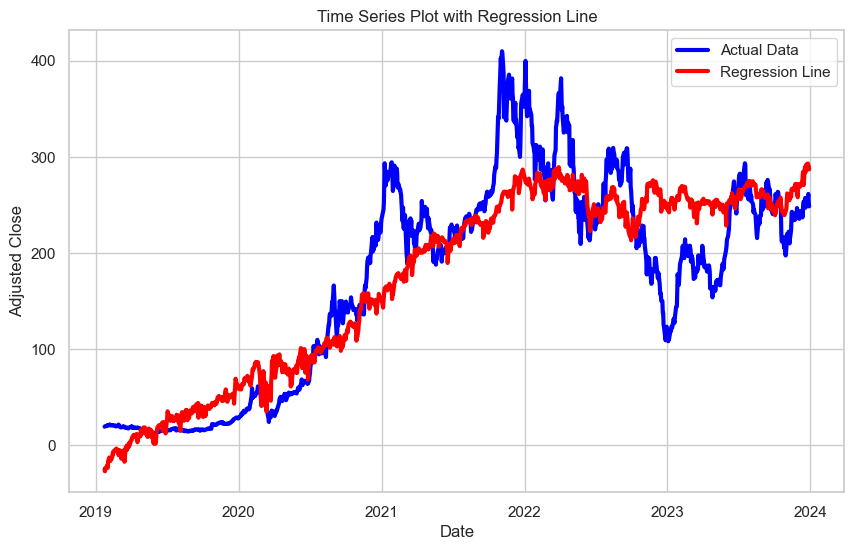

In [226]:
# Plotting settings for improved aesthetics (optional)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Scatter plot for actual data points
plt.plot(reg_data_single.index, reg_data_single['Adj Close'], color='blue', linewidth=3, label='Actual Data')

# Regression line
plt.plot(reg_data_single.index, model.predict(independent), color='red', linewidth=3, label='Regression Line')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.title('Time Series Plot with Regression Line')

# Display legend
plt.legend()

# Show the plot
plt.show()